
# The impact of CEO turnover on company culture

### William Zhu (wzhu4@uchicago.edu)



## 0. Importing packages

In [2]:
#Special module written for content analysis
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
plt.style.use('fivethirtyeight')
import matplotlib.cm #Still for graphics
import matplotlib.patches as mpatches
import seaborn as sns #Makes the graphics look nicer
import spacy
import nltk

#%matplotlib inline

import itertools
import json

Importing data

In [3]:
df = pandas.read_csv('clean_df.csv', index_col=0)

In [4]:
df.head()

,ID,text,category,year,cat_id,tokenized_text,normalized_tokens
0,1,Best Company to work for People are smart and ...,google,2018,2,"['Best', 'Company', 'to', 'work', 'for', 'Peop...","['well', 'company', 'work', 'people', 'smart',..."
1,2,"Moving at the speed of light, burn out is inev...",google,2013,2,"['Moving', 'at', 'the', 'speed', 'of', 'light'...","['move', 'speed', 'light', 'burn', 'inevitable..."
2,3,Great balance between big-company security and...,google,2014,2,"['Great', 'balance', 'between', 'big', 'compan...","['great', 'balance', 'big', 'company', 'securi..."
3,4,The best place I've worked and also the most d...,google,2015,2,"['The', 'best', 'place', 'I', ""'ve"", 'worked',...","['well', 'place', 'have', 'work', 'demand', 'f..."
4,10,Execellent for engineers Impact driven. Best t...,google,2018,2,"['Execellent', 'for', 'engineers', 'Impact', '...","['execellent', 'engineer', 'impact', 'drive', ..."


## 2. Overall review changes by year

### (2a) distributional distance

Prep

In [5]:
nlp = spacy.load("en")
nlp.max_length = 1800000

In [6]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [7]:
def operations(df, lim=100):
    #for years with more than 100 reviews, only sample 100 reviews.
    df = df.groupby('year').apply(lambda x: x.sample(lim, random_state=123) if len(x) > lim else x).reset_index(drop=True)
    #collapse the reviews to one row for each year
    df2 = df.groupby('year')['text'].apply(','.join).reset_index()
    df2['tokenized_text'] = df2['text'].apply(lambda x: lucem_illud.word_tokenize(x))
    return df2

In [8]:
def corpora_operation(df):
    corpora = []
    for i in range(df.shape[0]):
        corpora.append(df['tokenized_text'][i])
    corpora_s = []
    corpora_nons = []
    for corpus in corpora:
        s = []
        nons = []
        doc = nlp(' '.join(corpus))
        for word in doc:
            if word.is_stop:
                s.append(word.text)
            else:
                nons.append(word.text)
        corpora_s.append(s)
        corpora_nons.append(nons)
    return corpora_nons

In [9]:
# Create 6 datasets
 
df0 = df[df['cat_id']==0].reset_index()
df1 = df[df['cat_id']==1].reset_index()
df2 = df[df['cat_id']==2].reset_index()
df3 = df[df['cat_id']==3].reset_index()
df4 = df[df['cat_id']==4].reset_index()
df5 = df[df['cat_id']==5].reset_index()

### Start with df0 (amazon)

In [10]:
df0['year'].value_counts()

2018    7421
2017    6678
2016    4039
2015    2951
2014    1321
2013     784
2012     453
2011     117
2008      98
2009      68
2010      60
Name: year, dtype: int64

In [11]:
df_0 = operations(df0)
fileids = list(df_0['year'])
corpora_0 = corpora_operation(df_0)

In [28]:
def draw_div(key = 'KL', name = 'Amazon', corpora_nons=corpora_0):
    L = []
    for p in corpora_nons:
        l = []
        for q in corpora_nons:
            l.append(Divergence(p,q, difference=key))
        L.append(l)
    M = np.array(L)
    fig = plt.figure(figsize = (7,6))
    fig.set_facecolor('#f0fcfa')
    div = pandas.DataFrame(M, columns = fileids, index = fileids)
    ax = sns.heatmap(div)
    title = f"{key} divergence graph - {name}"
    plt.title(title, fontsize = 18) 
    #plt.show()
    plt.savefig(f'output_2/{name}-{key}.png', bbox_inches='tight')

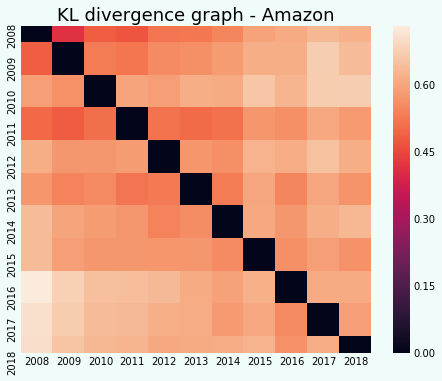

In [30]:
draw_div('KL', 'Amazon', corpora_0) #KL, Chi2, KS, Wasserstein

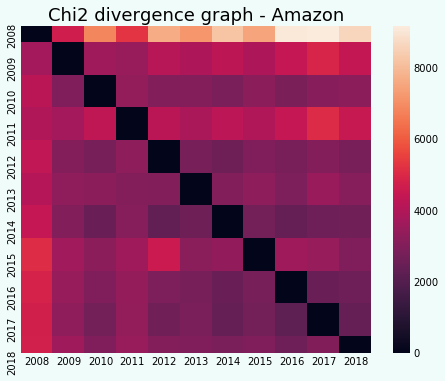

In [32]:
draw_div('Chi2', 'Amazon', corpora_0) #KL, Chi2, KS, Wasserstein

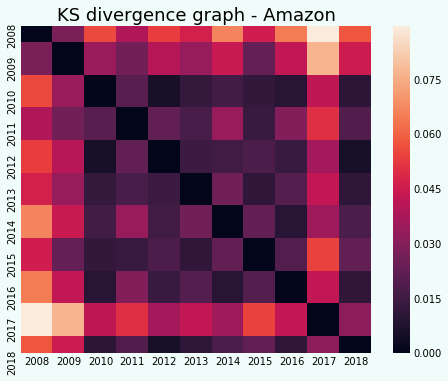

In [33]:
draw_div('KS', 'Amazon', corpora_0) #KL, Chi2, KS, Wasserstein


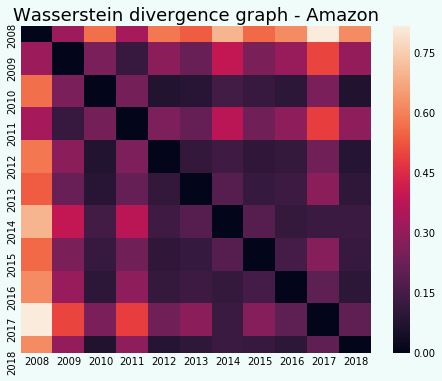

In [34]:
draw_div('Wasserstein', 'Amazon', corpora_0) #KL, Chi2, KS, Wasserstein

### df1 (Netflix)

In [35]:
df1['year'].value_counts()

2015    102
2018     94
2017     94
2016     83
2014     60
2013     55
2012     45
2009     44
2010     30
2008     28
2011     19
Name: year, dtype: int64

In [36]:
df_1 = operations(df1)
fileids = list(df_1['year'])
corpora_1 = corpora_operation(df_1)

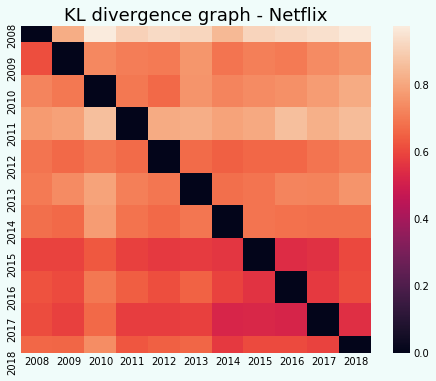

In [37]:
draw_div('KL', 'Netflix', corpora_1) #KL, Chi2, KS, Wasserstein

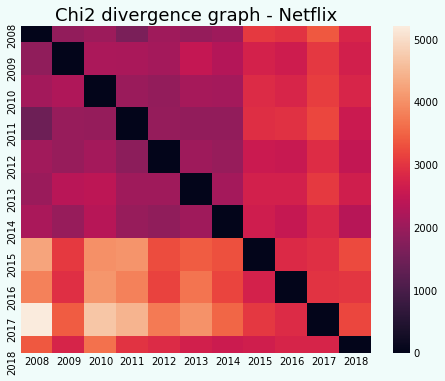

In [38]:
draw_div('Chi2', 'Netflix', corpora_1) #KL, Chi2, KS, Wasserstein

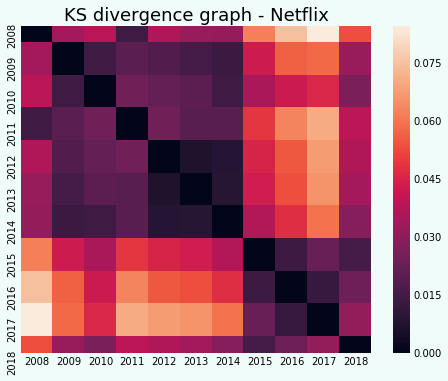

In [39]:
draw_div('KS', 'Netflix', corpora_1) #KL, Chi2, KS, Wasserstein

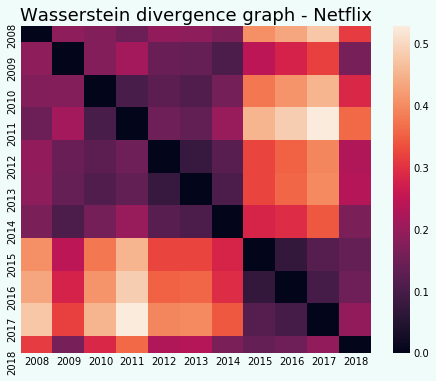

In [40]:
draw_div('Wasserstein', 'Netflix', corpora_1) #KL, Chi2, KS, Wasserstein

### df2 (Google)

In [41]:
df_2 = operations(df2)
fileids = list(df_2['year'])
corpora_2 = corpora_operation(df_2)

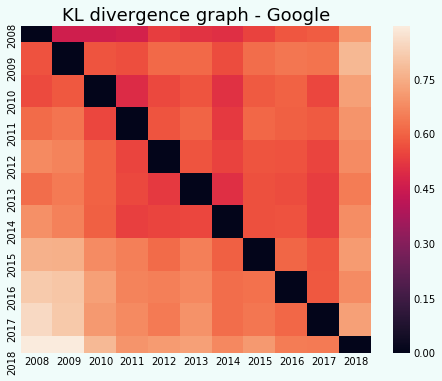

In [42]:
draw_div('KL', 'Google', corpora_2) #KL, Chi2, KS, Wasserstein

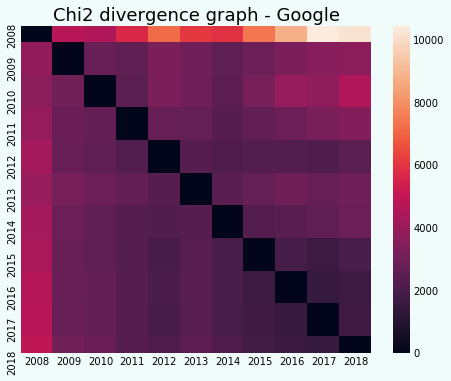

In [43]:
draw_div('Chi2', 'Google', corpora_2) #KL, Chi2, KS, Wasserstein

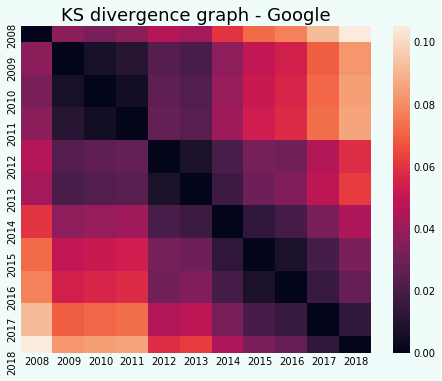

In [44]:
draw_div('KS', 'Google', corpora_2) #KL, Chi2, KS, Wasserstein

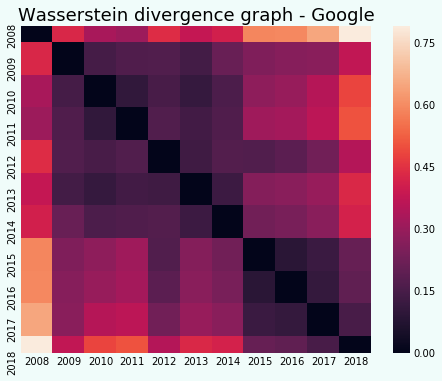

In [45]:
draw_div('Wasserstein', 'Google', corpora_2) #KL, Chi2, KS, Wasserstein

### df3 (Apple)

In [46]:
df_3 = operations(df3)
fileids = list(df_3['year'])
corpora_3 = corpora_operation(df_3)

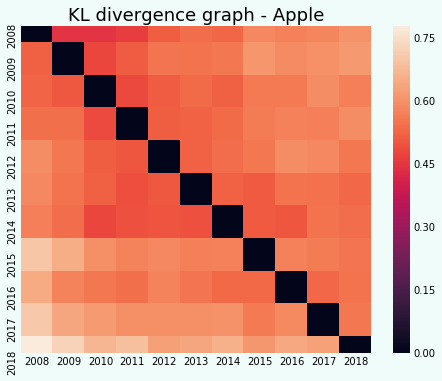

In [47]:
draw_div('KL', 'Apple', corpora_3) #KL, Chi2, KS, Wasserstein

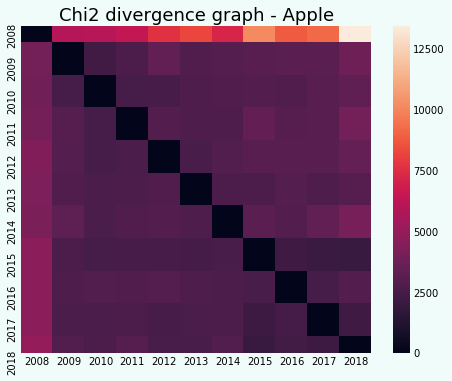

In [48]:
draw_div('Chi2', 'Apple', corpora_3) #KL, Chi2, KS, Wasserstein

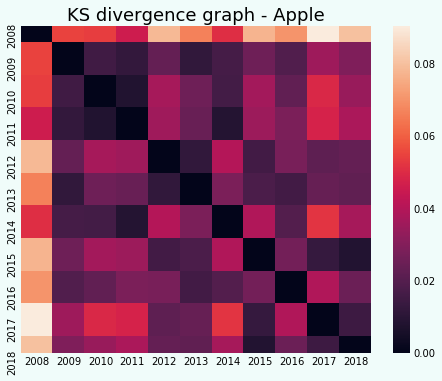

In [49]:
draw_div('KS', 'Apple', corpora_3) #KL, Chi2, KS, Wasserstein

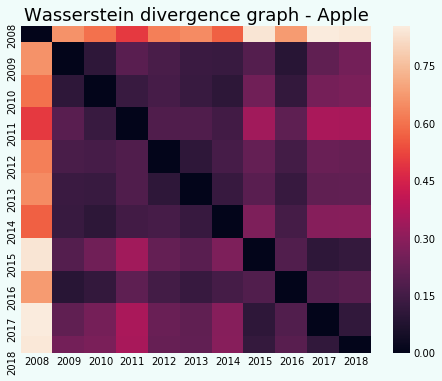

In [50]:
draw_div('Wasserstein', 'Apple', corpora_3) #KL, Chi2, KS, Wasserstein

### df4 (facebook)

In [51]:
df_4 = operations(df4)
fileids = list(df_4['year'])
corpora_4 = corpora_operation(df_4)

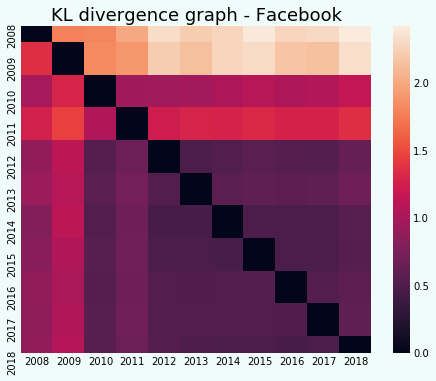

In [52]:
draw_div('KL', 'Facebook', corpora_4) #KL, Chi2, KS, Wasserstein

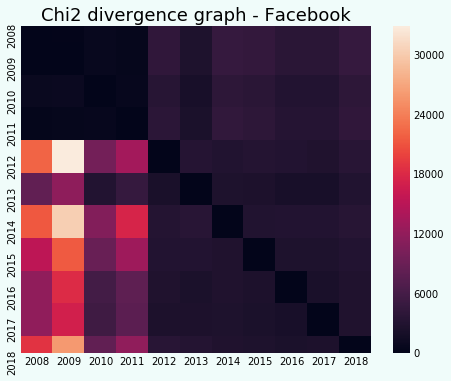

In [53]:
draw_div('Chi2', 'Facebook', corpora_4) #KL, Chi2, KS, Wasserstein

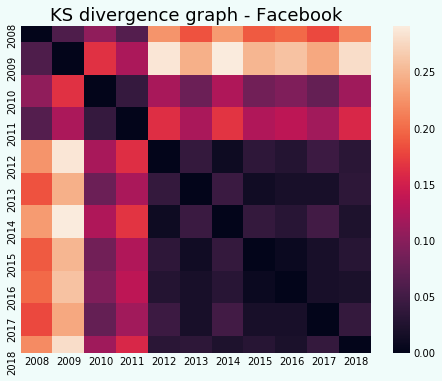

In [54]:
draw_div('KS', 'Facebook', corpora_4) #KL, Chi2, KS, Wasserstein

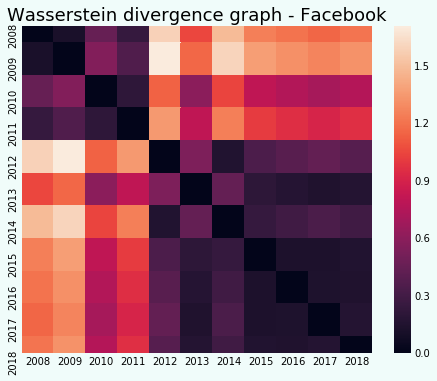

In [55]:
draw_div('Wasserstein', 'Facebook', corpora_4) #KL, Chi2, KS, Wasserstein

### df5 (Microsoft)

In [56]:
df_5 = operations(df5)
fileids = list(df_5['year'])
corpora_5 = corpora_operation(df_5)

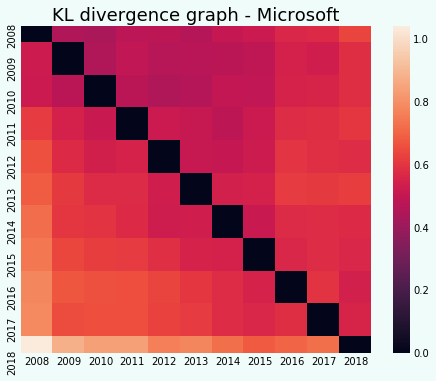

In [57]:
draw_div('KL', 'Microsoft', corpora_5) #KL, Chi2, KS, Wasserstein

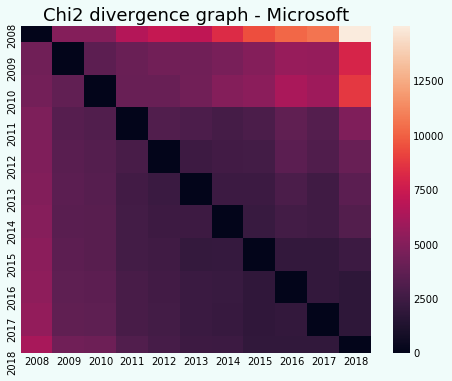

In [58]:
draw_div('Chi2', 'Microsoft', corpora_5) #KL, Chi2, KS, Wasserstein

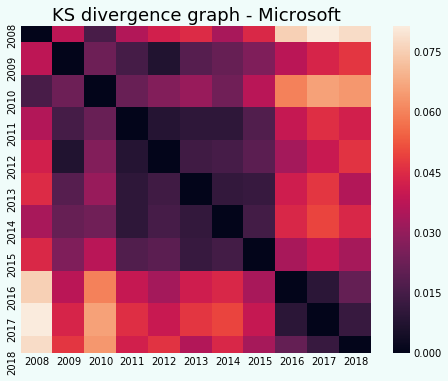

In [59]:
draw_div('KS', 'Microsoft', corpora_5) #KL, Chi2, KS, Wasserstein

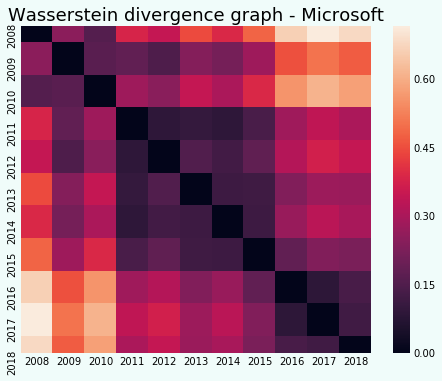

In [60]:
draw_div('Wasserstein', 'Microsoft', corpora_5) #KL, Chi2, KS, Wasserstein